# The purpose of this notebook is to build a binary classifier which will predict if the markets (S&P500) will close 'Green' or 'Red'.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import sklearn
import yfinance as yf

## Load Data

In [3]:
sp = yf.Ticker('SPY')

In [4]:
sp_df = sp.history(period='max')
sp_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1993-01-29,26.32,26.32,26.19,26.30,1003200,0.0,0
1993-02-01,26.32,26.49,26.32,26.49,480500,0.0,0
1993-02-02,26.47,26.56,26.41,26.54,201300,0.0,0
1993-02-03,26.58,26.84,26.56,26.82,529400,0.0,0
1993-02-04,26.92,26.99,26.62,26.94,531500,0.0,0


# EDA:

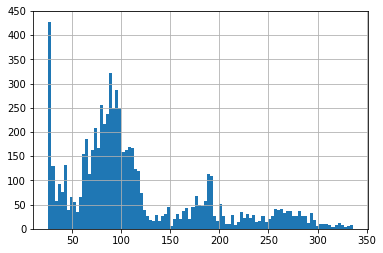

In [5]:
sp_df.Open.hist(bins=100)
plt.show()

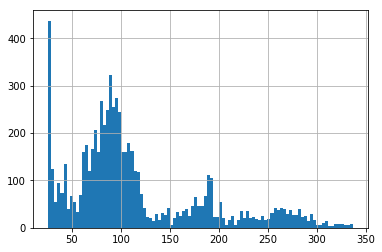

In [6]:
sp_df.Close.hist(bins=100)
plt.show()

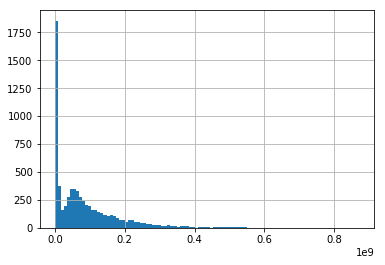

In [7]:
sp_df.Volume.hist(bins=100)
plt.show()

### What do days with 0 Volume correspond to?

In [8]:
sp_df.Volume.min()

5200

In [9]:
sp_df.Open.min(), sp_df.Close.min()

(25.98, 25.98)

# Preprocessing

In [10]:
print(sp_df['Stock Splits'].unique())
sp_df.Dividends.unique()

[0]


array([0.   , 0.213, 0.318, 0.286, 0.317, 0.271, 0.305, 0.288, 0.363,
       0.268, 0.316, 0.312, 0.382, 0.285, 0.351, 0.352, 0.367, 0.299,
       0.35 , 0.348, 0.38 , 0.313, 0.359, 0.392, 0.32 , 0.405, 0.372,
       0.371, 0.375, 0.411, 0.346, 0.369, 0.393, 0.331, 0.353, 0.378,
       0.436, 0.354, 0.36 , 0.4  , 0.516, 0.395, 0.414, 0.469, 0.568,
       0.467, 0.488, 0.522, 0.672, 0.519, 0.555, 0.579, 0.793, 0.551,
       0.656, 0.719, 0.775, 0.642, 0.669, 0.691, 0.561, 0.518, 0.508,
       0.59 , 0.48 , 0.531, 0.602, 0.653, 0.553, 0.628, 0.625, 0.77 ,
       0.614, 0.688, 0.779, 1.022, 0.694, 0.839, 0.838, 0.98 , 0.825,
       0.937, 0.939, 1.135, 0.931, 1.03 , 1.033, 1.212, 1.05 , 1.078,
       1.082, 1.329, 1.183, 1.235, 1.351, 1.097, 1.246, 1.323, 1.435,
       1.233, 1.432, 1.384, 1.57 , 1.406])

In [11]:
sp_df = sp_df.drop(columns=['Stock Splits','Dividends'])
sp_df.head()

,Open,High,Low,Close,Volume
Date,,,,,
1993-01-29,26.32,26.32,26.19,26.30,1003200
1993-02-01,26.32,26.49,26.32,26.49,480500
1993-02-02,26.47,26.56,26.41,26.54,201300
1993-02-03,26.58,26.84,26.56,26.82,529400
1993-02-04,26.92,26.99,26.62,26.94,531500


# Feature Engineering:

In [12]:
sp_df['day_change'] = sp_df.Close - sp_df.Open
sp_df.head()

,Open,High,Low,Close,Volume,day_change
Date,,,,,,
1993-01-29,26.32,26.32,26.19,26.30,1003200,-0.02
1993-02-01,26.32,26.49,26.32,26.49,480500,0.17
1993-02-02,26.47,26.56,26.41,26.54,201300,0.07
1993-02-03,26.58,26.84,26.56,26.82,529400,0.24
1993-02-04,26.92,26.99,26.62,26.94,531500,0.02


In [42]:
sp_df['close_label'] = sp_df.day_change.apply(lambda x: 1 if x > 0 else 0) # 'Green' == 1
sp_df.tail()

,Open,High,Low,Close,Volume,day_change,close_label,max_magnitude_change,largest_day_gain,largest_day_loss,day_sd,day_mean,cv,day_median
Date,,,,,,,,,,,,,,
2020-03-26,249.52,262.80,249.05,261.20,257632800,11.68,1,13.75,13.28,-1.60,6.384780,255.6425,40.039358,255.925
2020-03-27,253.27,260.81,251.05,253.42,224341200,0.15,1,9.76,7.54,-7.39,3.685182,254.6375,69.097667,255.930
2020-03-30,255.70,262.43,253.53,261.65,171369500,5.95,1,8.90,8.12,-2.17,3.800963,258.3275,67.963700,257.980
2020-03-31,260.56,263.33,256.22,257.75,194881100,-2.81,0,7.11,2.77,-5.58,2.720685,259.4650,95.367539,259.775
2020-04-01,247.98,257.66,243.90,246.15,188601200,-1.83,0,13.76,9.68,-11.51,5.247487,248.9225,47.436517,250.780


### close_label is our target. Given a sequence of days x1,...,xN we want to predict close_label on day xN+1.

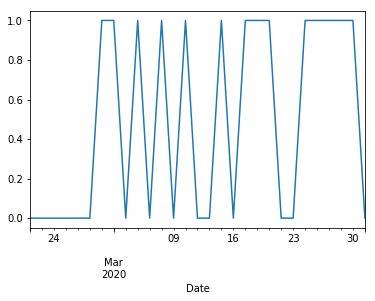

In [41]:
sp_df.close_label[-30:-1].plot()
plt.show()

In [15]:
sp_df['max_magnitude_change'] = np.abs(sp_df.High - sp_df.Low) # we don't know which came first
sp_df.head()

,Open,High,Low,Close,Volume,day_change,close_label,max_magnitude_change
Date,,,,,,,,
1993-01-29,26.32,26.32,26.19,26.30,1003200,-0.02,0,0.13
1993-02-01,26.32,26.49,26.32,26.49,480500,0.17,1,0.17
1993-02-02,26.47,26.56,26.41,26.54,201300,0.07,1,0.15
1993-02-03,26.58,26.84,26.56,26.82,529400,0.24,1,0.28
1993-02-04,26.92,26.99,26.62,26.94,531500,0.02,1,0.37


In [16]:
# the high or low will always come after the Open, the earliest they can come is at Open
sp_df['largest_day_gain'] = np.max([sp_df.High - sp_df.Open, sp_df.Close - sp_df.Low], axis=0)
sp_df['largest_day_loss'] = np.min([sp_df.Low - sp_df.Open, sp_df.Close - sp_df.High], axis=0)
sp_df.head()

,Open,High,Low,Close,Volume,day_change,close_label,max_magnitude_change,largest_day_gain,largest_day_loss
Date,,,,,,,,,,
1993-01-29,26.32,26.32,26.19,26.30,1003200,-0.02,0,0.13,0.11,-0.13
1993-02-01,26.32,26.49,26.32,26.49,480500,0.17,1,0.17,0.17,0.00
1993-02-02,26.47,26.56,26.41,26.54,201300,0.07,1,0.15,0.13,-0.06
1993-02-03,26.58,26.84,26.56,26.82,529400,0.24,1,0.28,0.26,-0.02
1993-02-04,26.92,26.99,26.62,26.94,531500,0.02,1,0.37,0.32,-0.30


In [17]:
sp_df.tail()

,Open,High,Low,Close,Volume,day_change,close_label,max_magnitude_change,largest_day_gain,largest_day_loss
Date,,,,,,,,,,
2020-03-26,249.52,262.80,249.05,261.20,257632800,11.68,1,13.75,13.28,-1.60
2020-03-27,253.27,260.81,251.05,253.42,224341200,0.15,1,9.76,7.54,-7.39
2020-03-30,255.70,262.43,253.53,261.65,171369500,5.95,1,8.90,8.12,-2.17
2020-03-31,260.56,263.33,256.22,257.75,194881100,-2.81,0,7.11,2.77,-5.58
2020-04-01,247.98,257.66,243.90,246.15,188601200,-1.83,0,13.76,9.68,-11.51


In [34]:
sp_df['day_sd'] = np.std([sp_df.Open, sp_df.High, sp_df.Low, sp_df.Close], axis=0)
sp_df['day_mean'] = np.mean([sp_df.Open, sp_df.High, sp_df.Low, sp_df.Close], axis=0)
sp_df['day_median'] = np.median([sp_df.Low, sp_df.High], axis=0)
sp_df.tail()

,Open,High,Low,Close,Volume,day_change,close_label,max_magnitude_change,largest_day_gain,largest_day_loss,day_sd,day_mean,cv,day_median
Date,,,,,,,,,,,,,,
2020-03-26,249.52,262.80,249.05,261.20,257632800,11.68,1,13.75,13.28,-1.60,6.384780,255.6425,40.039358,255.925
2020-03-27,253.27,260.81,251.05,253.42,224341200,0.15,1,9.76,7.54,-7.39,3.685182,254.6375,69.097667,255.930
2020-03-30,255.70,262.43,253.53,261.65,171369500,5.95,1,8.90,8.12,-2.17,3.800963,258.3275,67.963700,257.980
2020-03-31,260.56,263.33,256.22,257.75,194881100,-2.81,0,7.11,2.77,-5.58,2.720685,259.4650,95.367539,259.775
2020-04-01,247.98,257.66,243.90,246.15,188601200,-1.83,0,13.76,9.68,-11.51,5.247487,248.9225,47.436517,250.780


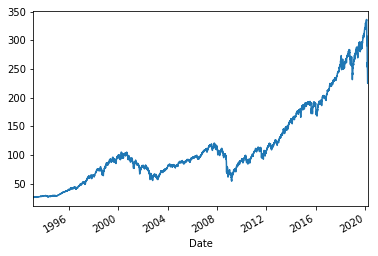

In [19]:
sp_df.day_mean.plot()
plt.show()

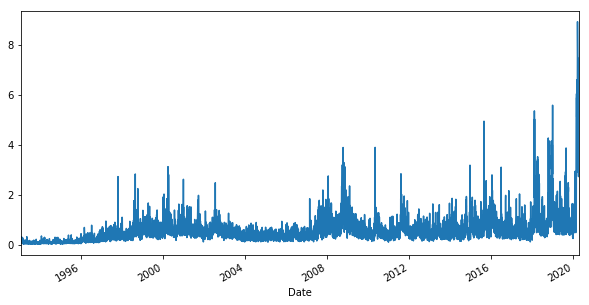

In [20]:
fig,ax = plt.subplots(figsize=(10,5))
sp_df.day_sd.plot()
plt.show()

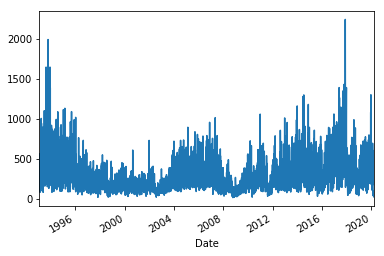

In [21]:
sp_df['cv'] = sp_df.day_mean/sp_df.day_sd
sp_df.cv.plot()
plt.show()

# Explore relationships between our features:

### Relationship between largest intraday gain and close label (Green 1, or Red 0)

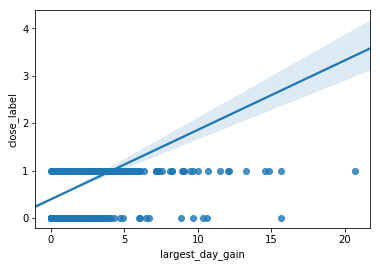

In [22]:
import seaborn as sns
sns.regplot(x='largest_day_gain', y='close_label', data=sp_df)
plt.show()

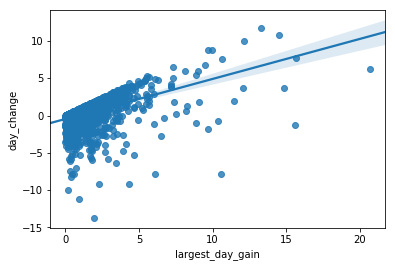

In [23]:
sns.regplot(x='largest_day_gain', y='day_change', data=sp_df)
plt.show()

### Relationship between largest intraday loss and close label and daily change

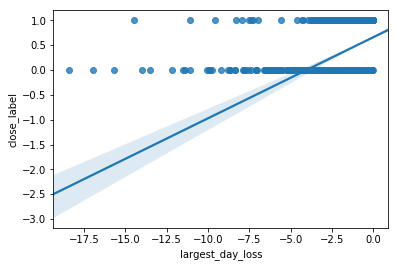

In [24]:
sns.regplot(x='largest_day_loss', y='close_label', data=sp_df)
plt.show()

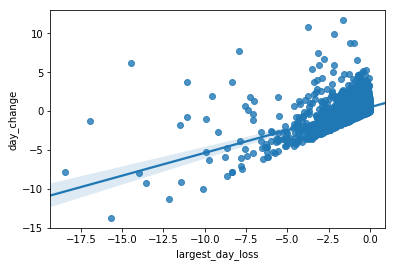

In [25]:
sns.regplot(x='largest_day_loss', y='day_change', data=sp_df)
plt.show()

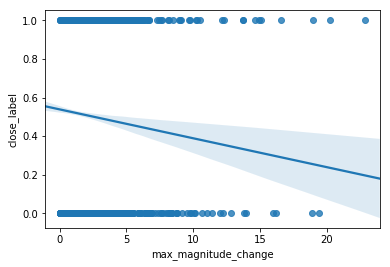

In [26]:
sns.regplot(x='max_magnitude_change', y='close_label', data=sp_df)
plt.show()

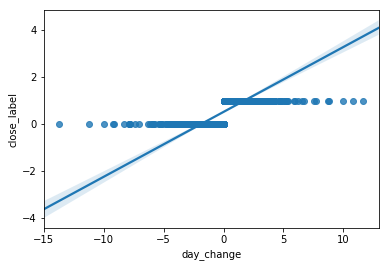

In [27]:
sns.regplot(x='day_change', y='close_label', data=sp_df)
plt.show()

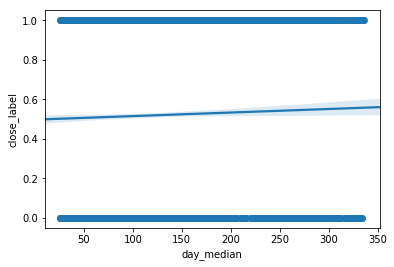

In [35]:
sns.regplot(x='day_median', y='close_label', data=sp_df)
plt.show()

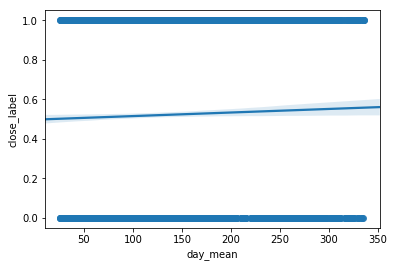

In [36]:
sns.regplot(x='day_mean', y='close_label', data=sp_df)
plt.show()

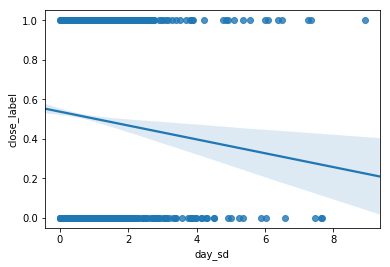

In [37]:
sns.regplot(x='day_sd', y='close_label', data=sp_df)
plt.show()

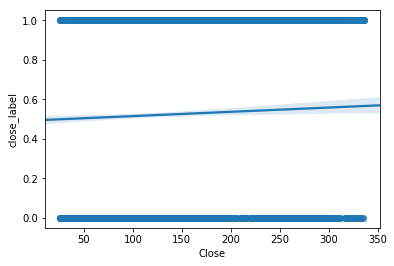

In [38]:
sns.regplot(x='Close', y='close_label', data=sp_df)
plt.show()

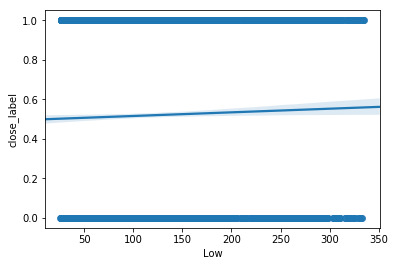

In [39]:
sns.regplot(x='Low', y='close_label', data=sp_df)
plt.show()

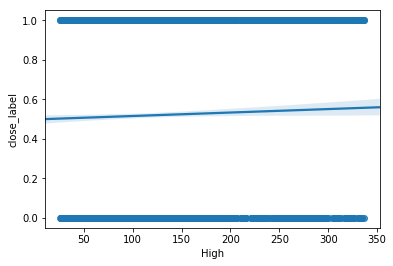

In [40]:
sns.regplot(x='High', y='close_label', data=sp_df)
plt.show()

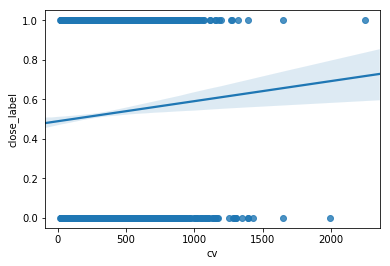

In [55]:
sns.regplot(x='cv', y='close_label', data=sp_df)
plt.show()

# Examine distributions of our features:

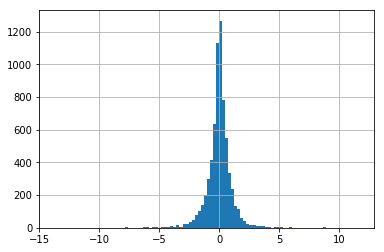

In [28]:
sp_df.day_change.hist(bins=100)
plt.show()

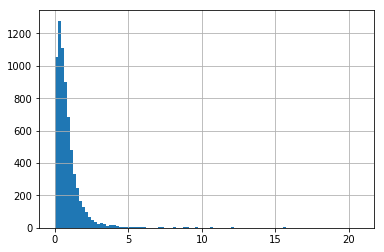

In [29]:
sp_df.largest_day_gain.hist(bins=100)
plt.show()

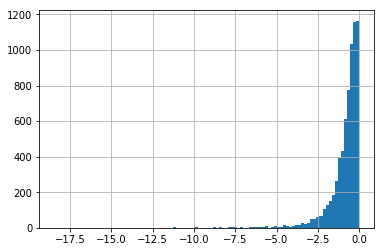

In [30]:
sp_df.largest_day_loss.hist(bins=100)
plt.show()

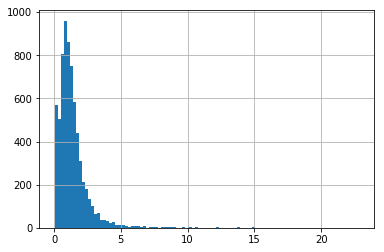

In [31]:
sp_df.max_magnitude_change.hist(bins=100)
plt.show()

# I'd really like intraday data to make better features:
    -percent time spent above open ; below close
    -num times cross open
    -etc

In [44]:
sp_df.head()

,Open,High,Low,Close,Volume,day_change,close_label,max_magnitude_change,largest_day_gain,largest_day_loss,day_sd,day_mean,cv,day_median
Date,,,,,,,,,,,,,,
1993-01-29,26.32,26.32,26.19,26.30,1003200,-0.02,0,0.13,0.11,-0.13,0.054025,26.2825,486.483622,26.255
1993-02-01,26.32,26.49,26.32,26.49,480500,0.17,1,0.17,0.17,0.00,0.085000,26.4050,310.647059,26.405
1993-02-02,26.47,26.56,26.41,26.54,201300,0.07,1,0.15,0.13,-0.06,0.059372,26.4950,446.256303,26.485
1993-02-03,26.58,26.84,26.56,26.82,529400,0.24,1,0.28,0.26,-0.02,0.130384,26.7000,204.779652,26.700
1993-02-04,26.92,26.99,26.62,26.94,531500,0.02,1,0.37,0.32,-0.30,0.145151,26.8675,185.100620,26.805


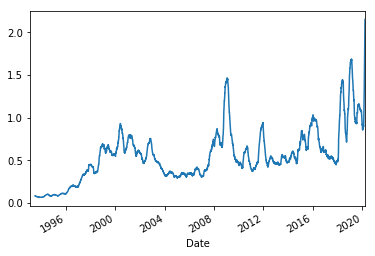

In [53]:
sp_df.rolling(window=100).day_sd.mean().plot()
plt.show()

# Let's try some modeling:

In [ ]:
# day_sd, max magnitude change, largest day gain/loss, cv had strongest correlations

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [69]:
X = sp_df[['Open', 'High', 'Low', 'Close', 'max_magnitude_change', 
           'largest_day_gain', 'largest_day_loss', 'day_sd', 'cv']]
y = sp_df[['close_label']]
y = np.reshape(y.values, (len(X),))
y

array([0, 1, 1, ..., 1, 0, 0], dtype=int64)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [67]:
rf_clf = RandomForestClassifier()

In [71]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [72]:
rf_clf.feature_importances_

array([0.01298183, 0.01287117, 0.01209038, 0.02465815, 0.03993074,
       0.38274006, 0.42706955, 0.06572304, 0.02193508])

## The largest day_loss, followed by the largest_day_gain were the most import features. Followed by day_sd. The other features had almost no predictive power :(

In [76]:
preds = rf_clf.predict(X_test)
preds

array([1, 1, 1, ..., 0, 1, 0], dtype=int64)

In [75]:
y_test

array([1, 1, 1, ..., 0, 1, 0], dtype=int64)

In [77]:
np.allclose(preds, y_test)

False

In [78]:
from sklearn.metrics import confusion_matrix

In [79]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
(tn, fp, fn, tp)

(1088, 18, 54, 1099)

In [80]:
tpr = tp/(tp+fn)
fpr = fp/(fp+tn)

In [81]:
tpr

0.9531656548135299

In [82]:
fpr

0.0162748643761302

## I think my model is overfitting...